In [1]:
# https://gee-community-catalog.org/projects/annual_nlcd/#earth-engine-snippet
import ee
import xarray as xr
import pandas as pd
import numpy as np
import dask.array as da
import xee
from bbox import * 
from datetime import datetime
import pygeohydro as ph


# Trigger the authentication flow
ee.Authenticate()

# Initialize the Earth Engine library
ee.Initialize(project='satellite-modeling')

# Define the rectangle that encompasses Louisiana and Texas
bbox = ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])

start_date = '2023-08-01T00:00'
end_date = datetime.now().strftime('%Y-%m-%dT%H:%M')

In [3]:
##################################################
# Impervious Area Data
##################################################

# List of climate variables to download from NLDAS
variables = ['Fractional Impervious Surface']
# Load NLDAS hourly data and filter by region and date
dataset = ee.ImageCollection("projects/sat-io/open-datasets/USGS/ANNUAL_NLCD/FRACTIONAL_IMPERVIOUS_SURFACE") \
            .filterBounds(bbox) 

ds = xr.open_dataset(dataset, engine='ee', crs='EPSG:4326', scale=0.01)
# Filter the dataset based on the latitude and longitude bounds
ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
ds = ds.fillna(0)
ds = ds.isel(time=-1)
ds= ds.rename({'b1':'impervious_area'})
ds.to_netcdf('../../data/other/impervious_area.nc')

In [2]:
##################################################
# Population Density Data
##################################################

# List of climate variables to download from NLDAS
variables =['population']

# Load NLDAS hourly data and filter by region and date
dataset = ee.ImageCollection("WorldPop/GP/100m/pop_age_sex") \
            .filterBounds(bbox) \
            .select(variables)

ds = xr.open_dataset(dataset, engine='ee', crs='EPSG:4326', scale=0.01)
# Filter the dataset based on the latitude and longitude bounds
ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
ds = ds.isel(time=3)
ds = ds.fillna(0)
ds.to_netcdf('../../data/other/population_density.nc')

In [ ]:
##################################################
# Elevation Data
##################################################

# Define the bounding box as an ee.Geometry.Rectangle
bbox = ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])

# Load the SRTM elevation image
image = ee.Image("CGIAR/SRTM90_V4")

i = ee.ImageCollection(ee.Image("CGIAR/SRTM90_V4"))
ds = xr.open_dataset(i, engine='ee', crs='EPSG:4326', scale=0.01)
ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
ds = ds.fillna(0)
ds.to_netcdf(f'../../data/other/elevation.nc', engine='h5netcdf')

In [7]:
##################################################
# Tree Cover Data
##################################################
# List of climate variables to download from NLDAS
variables = ['Percent_Tree_Cover', 'Percent_NonTree_Vegetation', 'Percent_NonVegetated']
# Load NLDAS hourly data and filter by region and date
dataset = ee.ImageCollection("MODIS/061/MOD44B") \
            .filterBounds(bbox) \
            .select(variables)

ds = xr.open_dataset(dataset, engine='ee', crs='EPSG:4326', scale=0.01)
# Filter the dataset based on the latitude and longitude bounds
ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
# Select most recent date (NOTE: There is now a 2024 date
ds = ds.sel(time='2023-03-06T00:00:00.000000000')
# Fill nulls over water
ds['Percent_Tree_Cover']=ds['Percent_Tree_Cover'].fillna(0)
ds['Percent_NonTree_Vegetation']=ds['Percent_NonTree_Vegetation'].fillna(0)
ds['Percent_NonVegetated']=ds['Percent_NonVegetated'].fillna(100)
ds.to_netcdf(f'../../data/other/tree_cover.nc', engine='h5netcdf')

In [20]:
##################################################
# LAND-WATER Data
##################################################
# OUTDATED
# List of climate variables to download from NLDAS
variables =['LW']

# Load NLDAS hourly data and filter by region and date
dataset = ee.ImageCollection('MODIS/061/MCD12Q1') \
            .filterDate(start_date, end_date) \
            .filterBounds(bbox) \
            .select(variables)

ds = xr.open_dataset(dataset, engine='ee', crs='EPSG:4326', scale=0.01)
# Filter the dataset based on the latitude and longitude bounds
ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
ds['LW'] = ds['LW'].where(ds['LW']!= 2, 0)
ds.to_netcdf(f'../../data/other/water_map.nc')

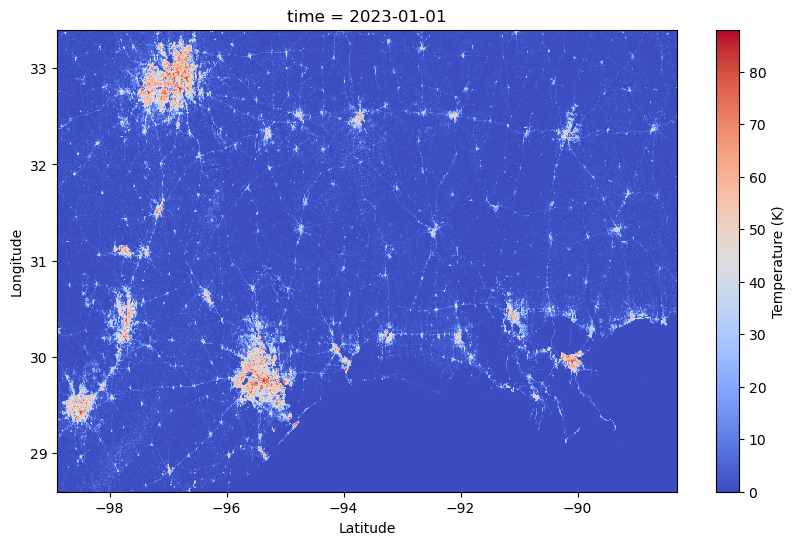

In [7]:
### Impervious Surface
import matplotlib.pyplot as plt

# Select one hour of temperature data (e.g., the first timestamp)
# hour_index = 0  # Change this to select a different hour if desired
impervious_area = ds['impervious_area']

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
temperature_data.T.plot(
    cmap="coolwarm",  # Colormap for temperature visualization
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()